# Body Fat Estimator: End-to-End Machine Learning Pipeline
This notebook demonstrates a complete workflow for building a body fat estimation model using machine learning. It covers data exploration, outlier detection, feature selection, model comparison, and final model deployment. The final model is saved for easy integration with a Streamlit web app.

## Importing Required Libraries
We import all necessary libraries for data manipulation, visualization, and machine learning.

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

## Loading the Body Fat Dataset
We load the dataset containing body fat measurements and related features.

In [61]:
data = pd.read_csv('./bodyfat.csv')
data.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


## Checking for Missing Values
We check for missing values in the dataset to ensure data quality before proceeding.

In [62]:
data.isnull().sum()

Density    0
BodyFat    0
Age        0
Weight     0
Height     0
Neck       0
Chest      0
Abdomen    0
Hip        0
Thigh      0
Knee       0
Ankle      0
Biceps     0
Forearm    0
Wrist      0
dtype: int64

## Visualizing Feature Distributions
We visualize the distributions of each feature and the target variable to understand their characteristics and relationships.

Distribution plots for Density


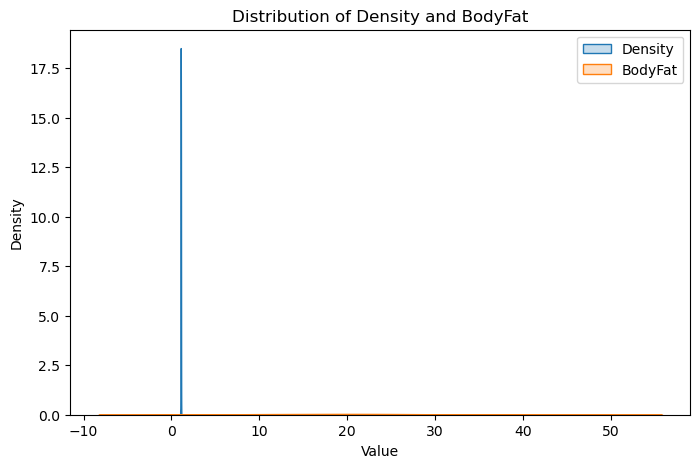

Distribution plots for BodyFat
Distribution plots for Age


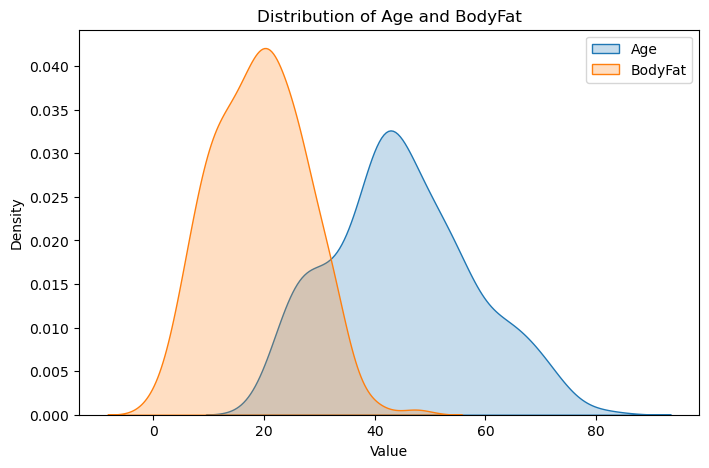

Distribution plots for Weight


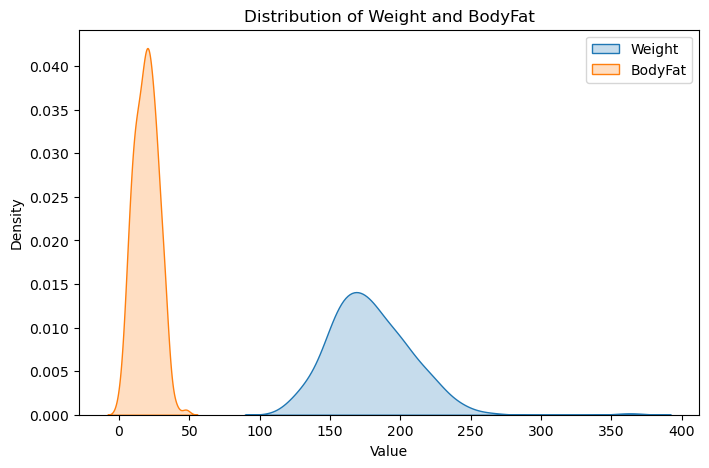

Distribution plots for Height


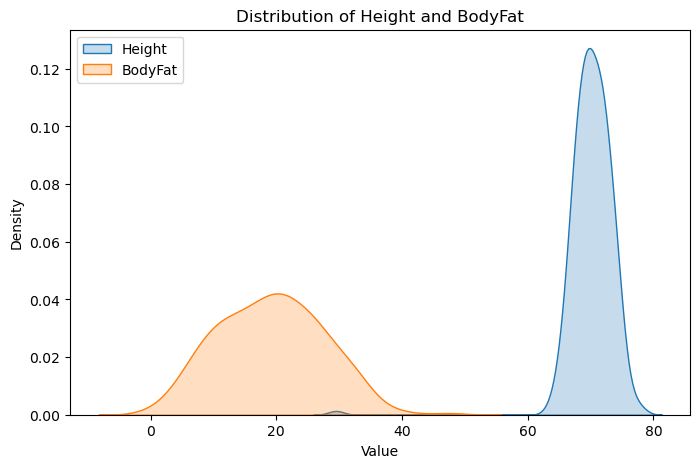

Distribution plots for Neck


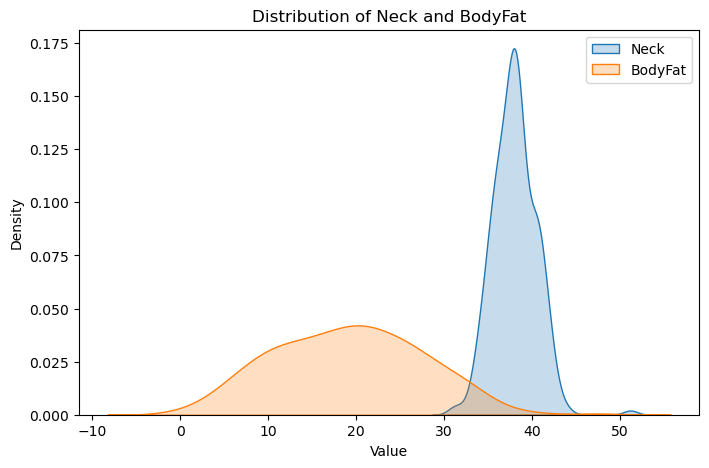

Distribution plots for Chest


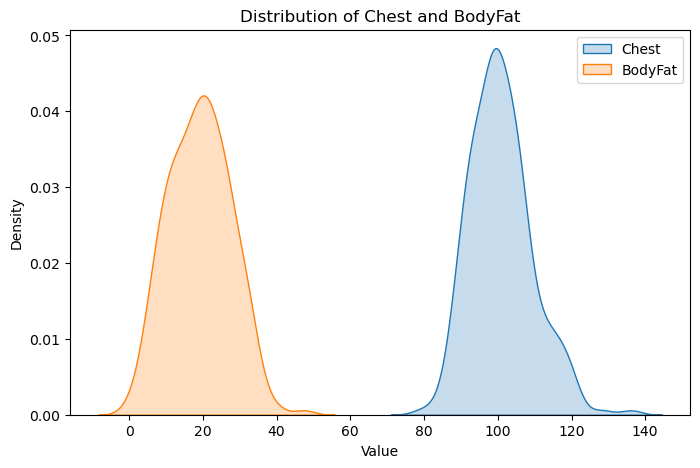

Distribution plots for Abdomen


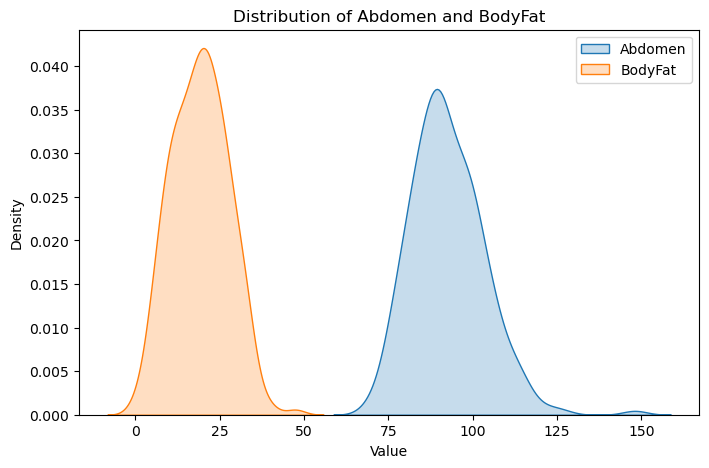

Distribution plots for Hip


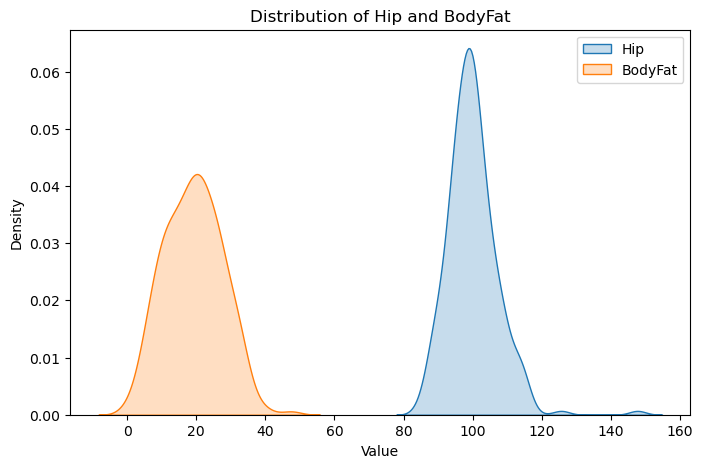

Distribution plots for Thigh


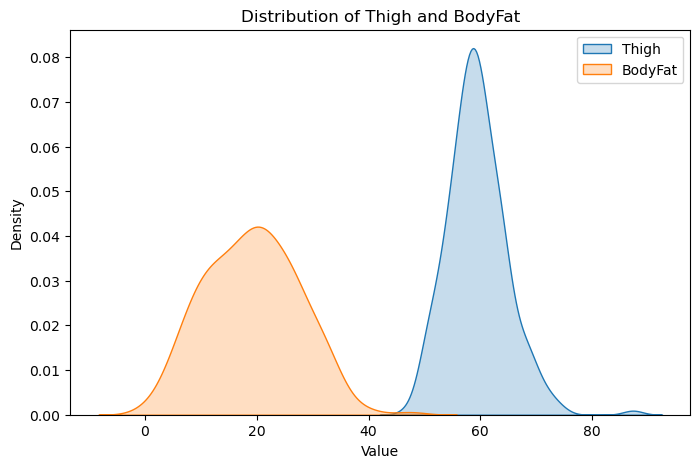

Distribution plots for Knee


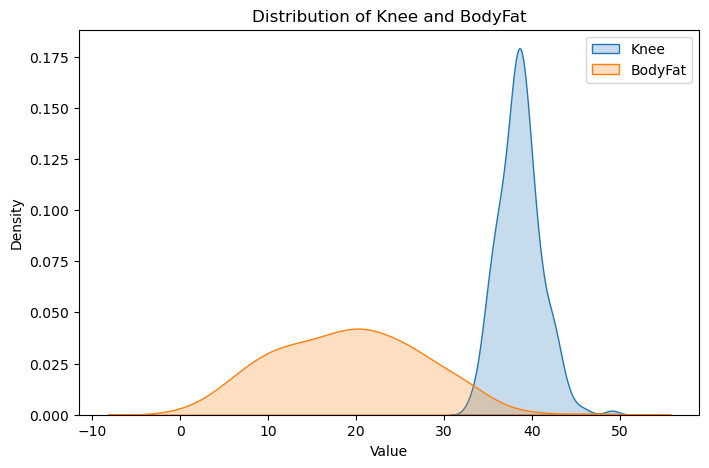

Distribution plots for Ankle


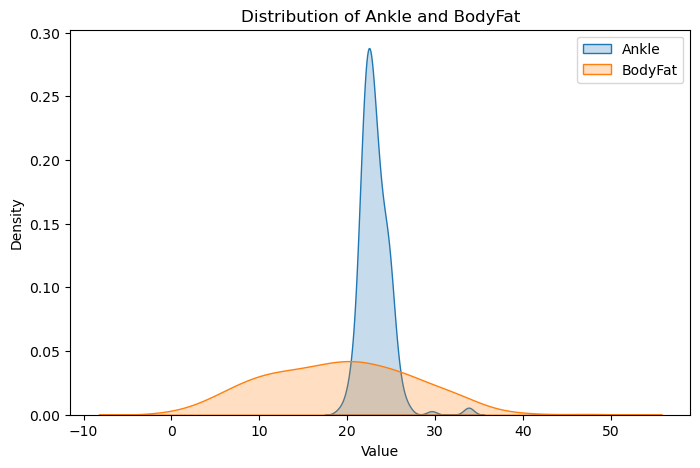

Distribution plots for Biceps


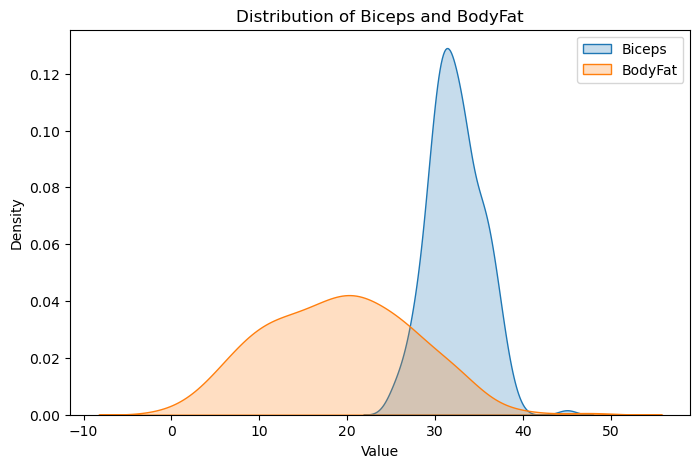

Distribution plots for Forearm


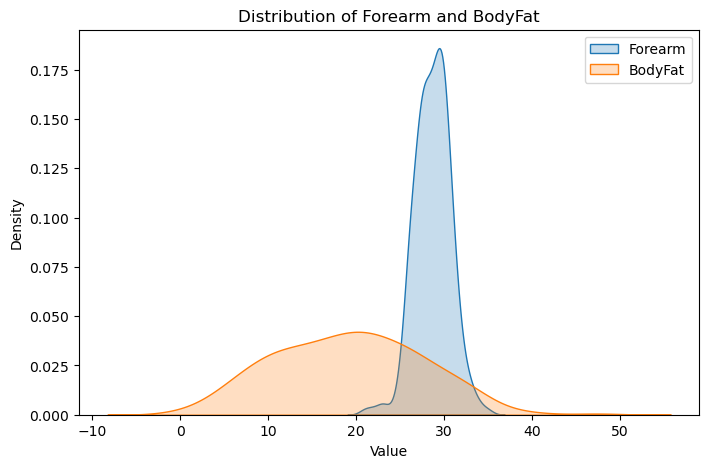

Distribution plots for Wrist


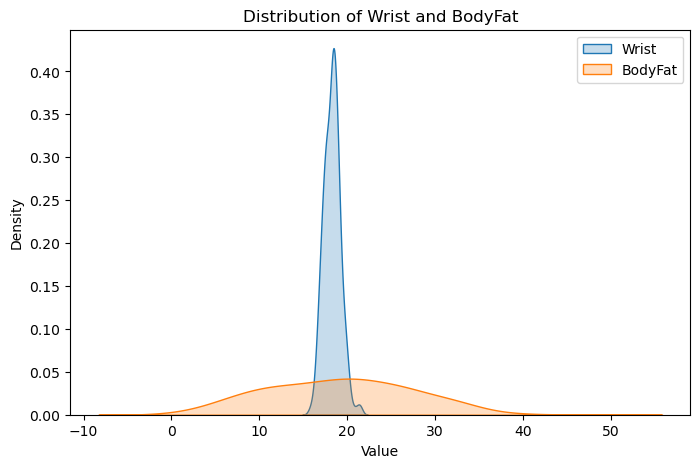

In [63]:
def kdeplot(column):
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data[column], label=column, fill=True)
    sns.kdeplot(data['BodyFat'], label='BodyFat', fill=True)
    plt.title(f'Distribution of {column} and BodyFat')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

columns = list(data.columns)
for col in columns:
    print(f'Distribution plots for {col}')
    if col != 'BodyFat':
        kdeplot(col)

## Exploring Feature Distributions with Plots
We use histograms, boxplots, and Q-Q plots to further explore the distribution and normality of each feature.

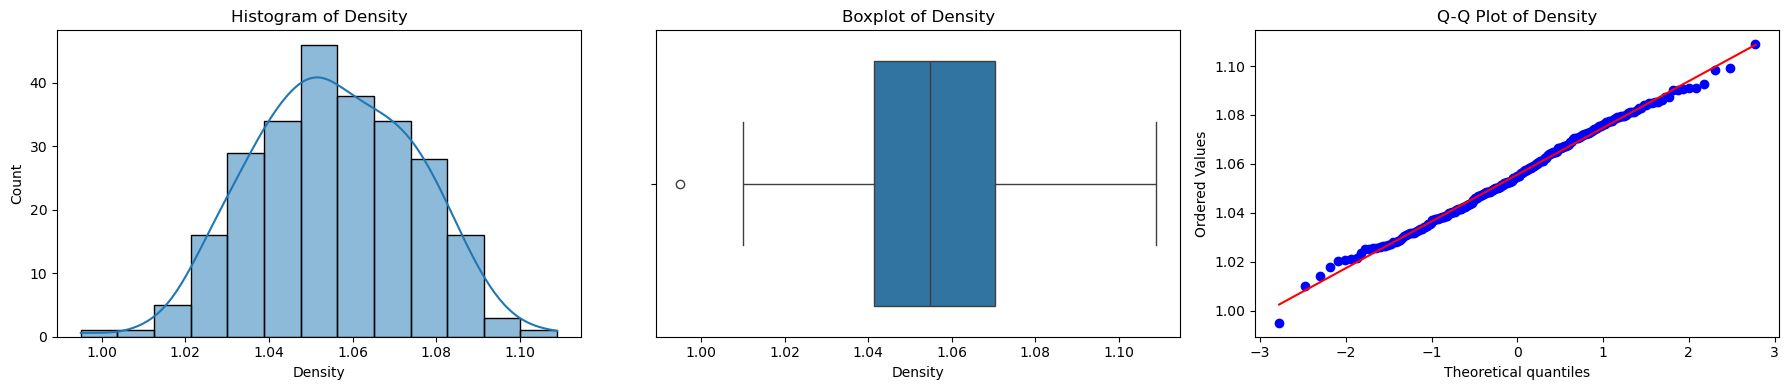

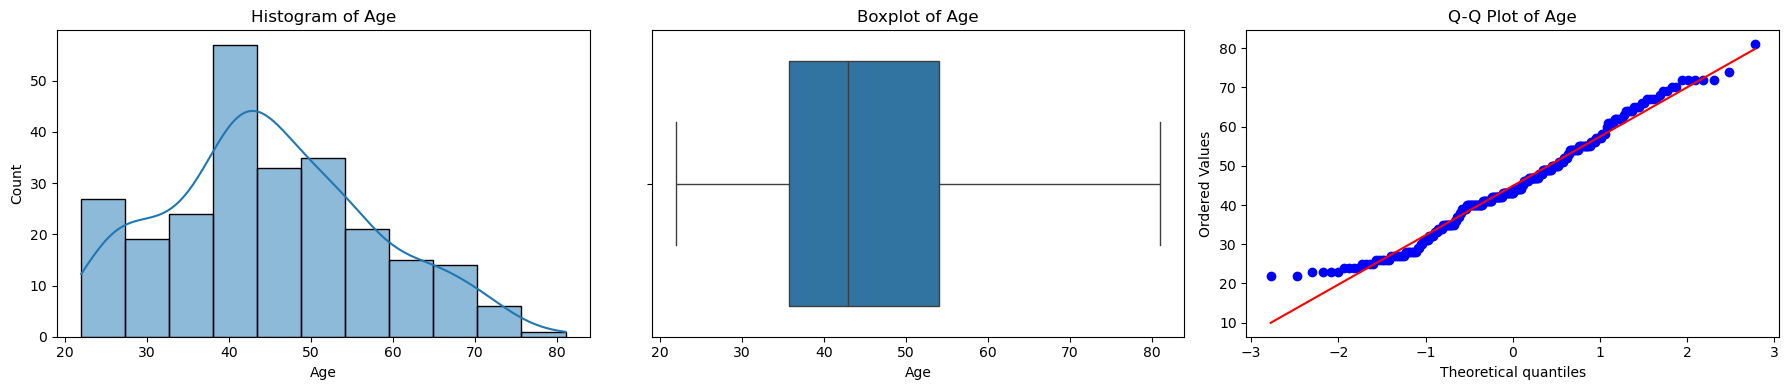

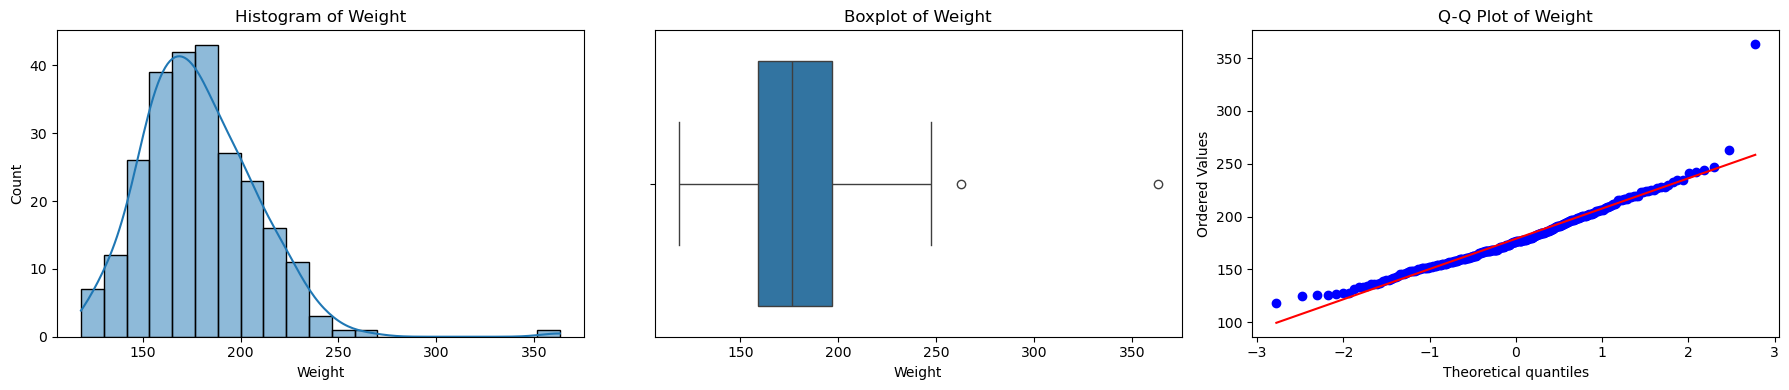

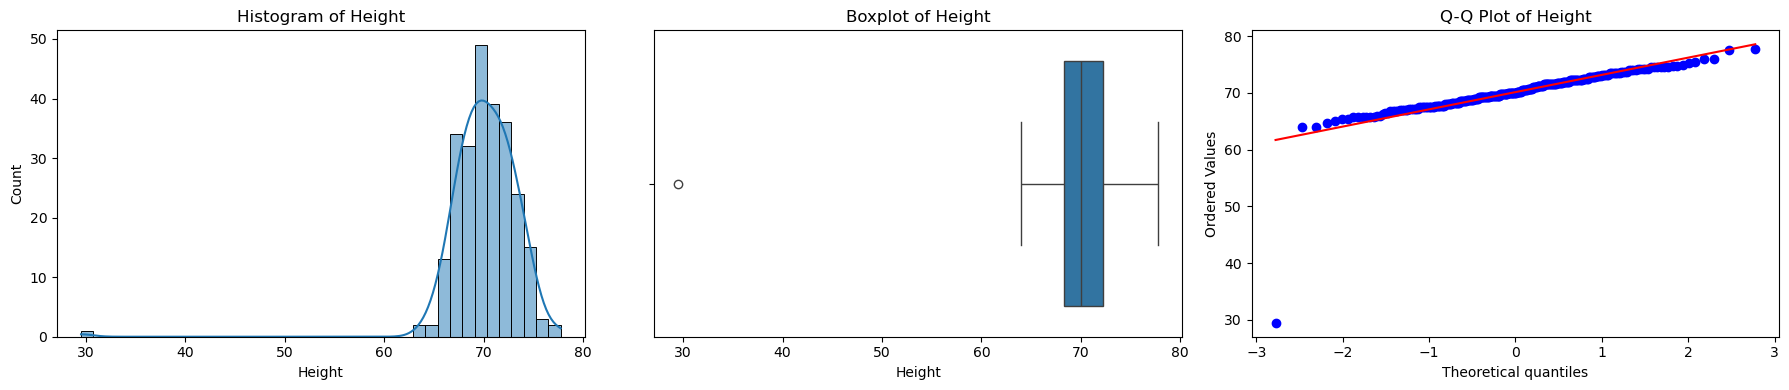

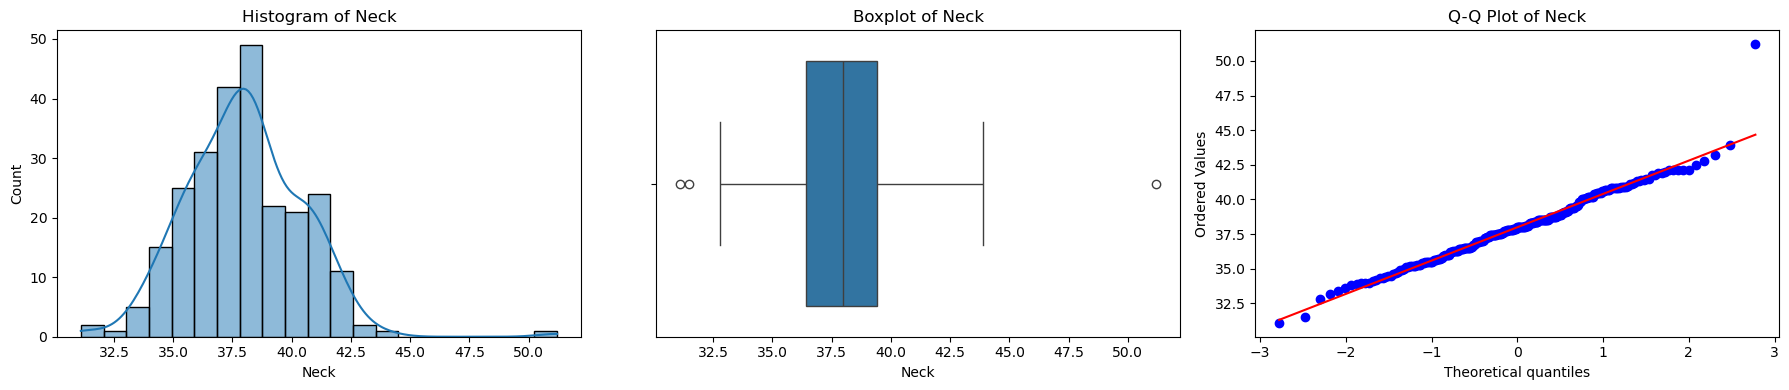

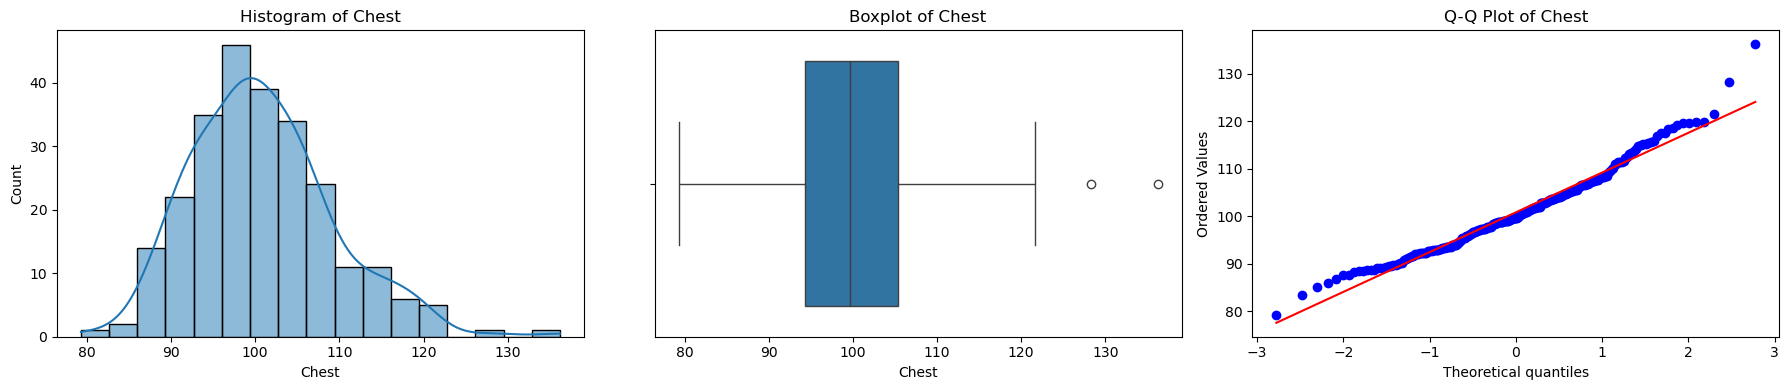

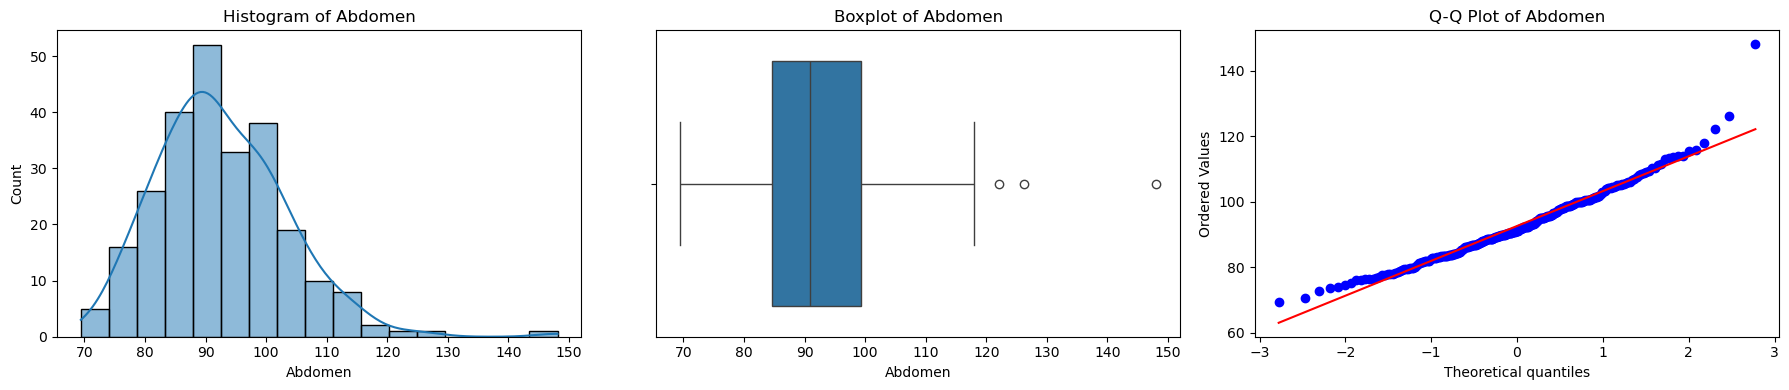

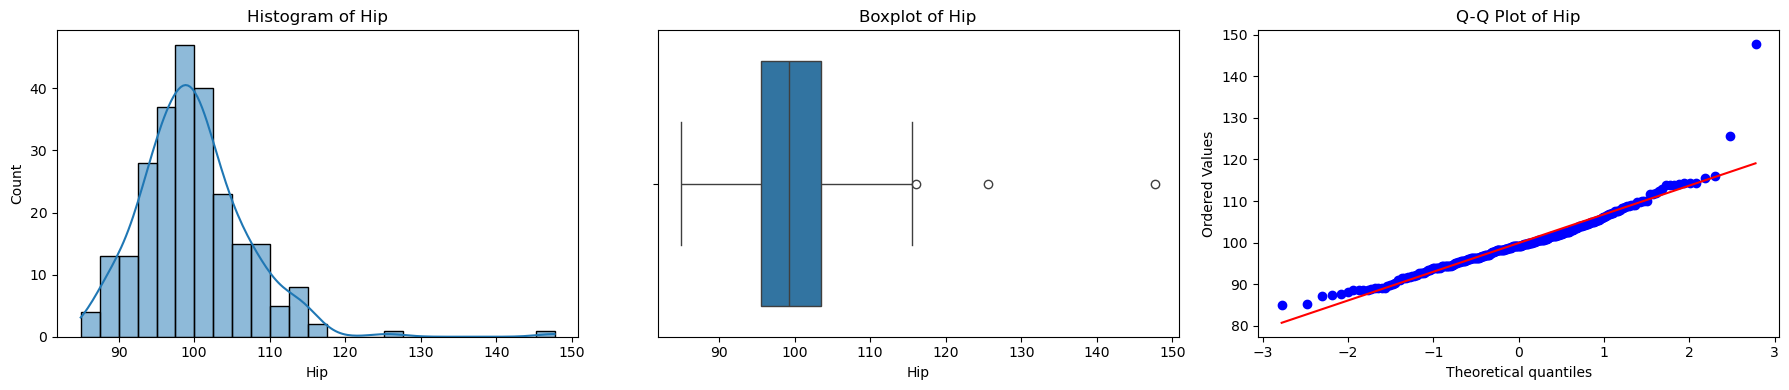

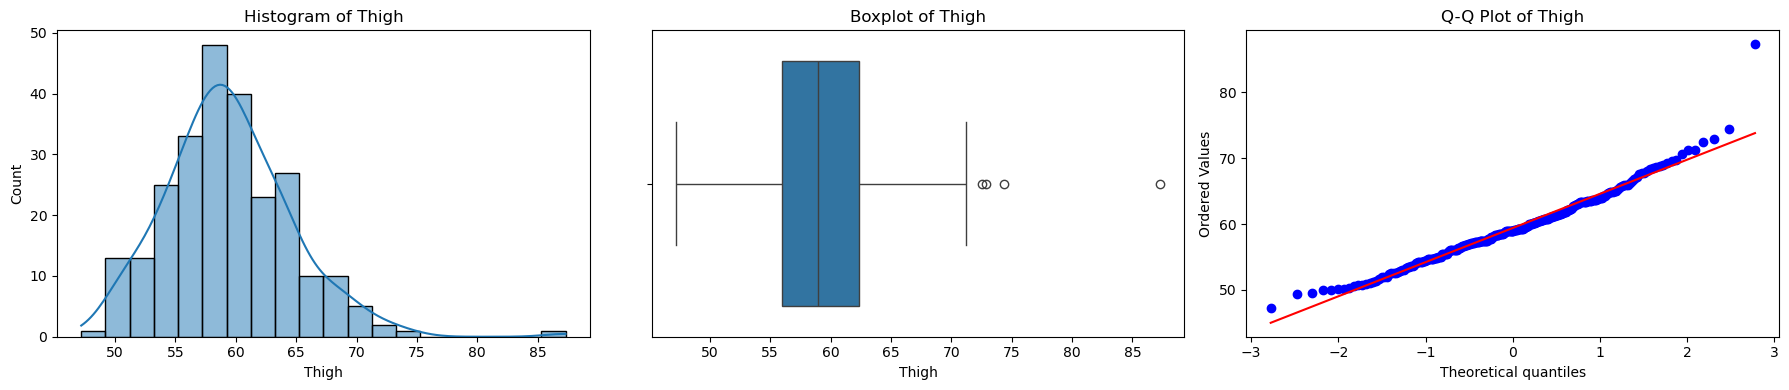

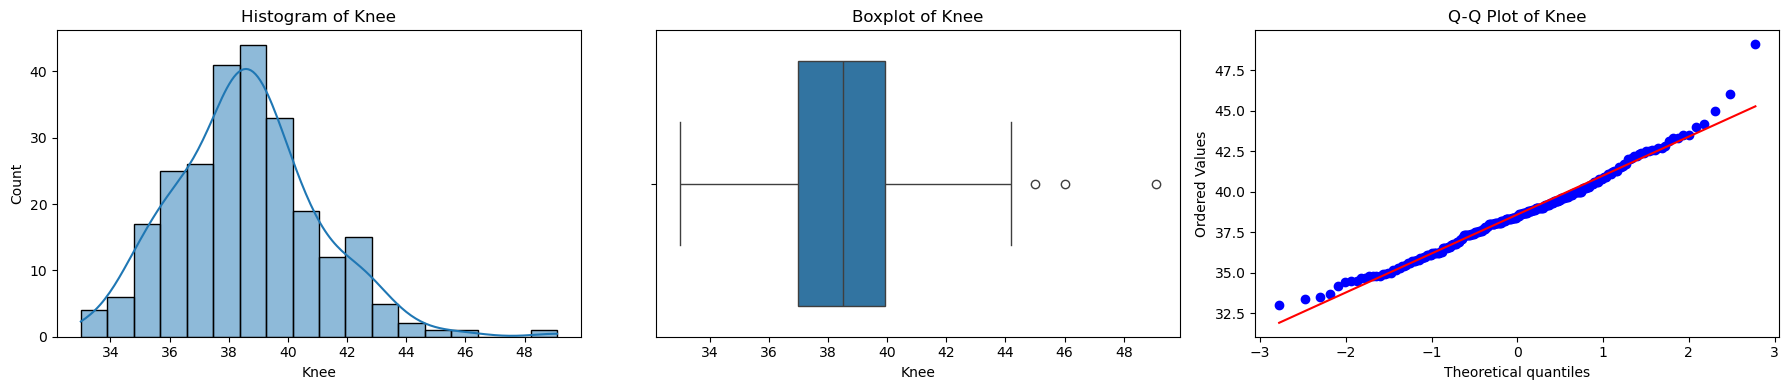

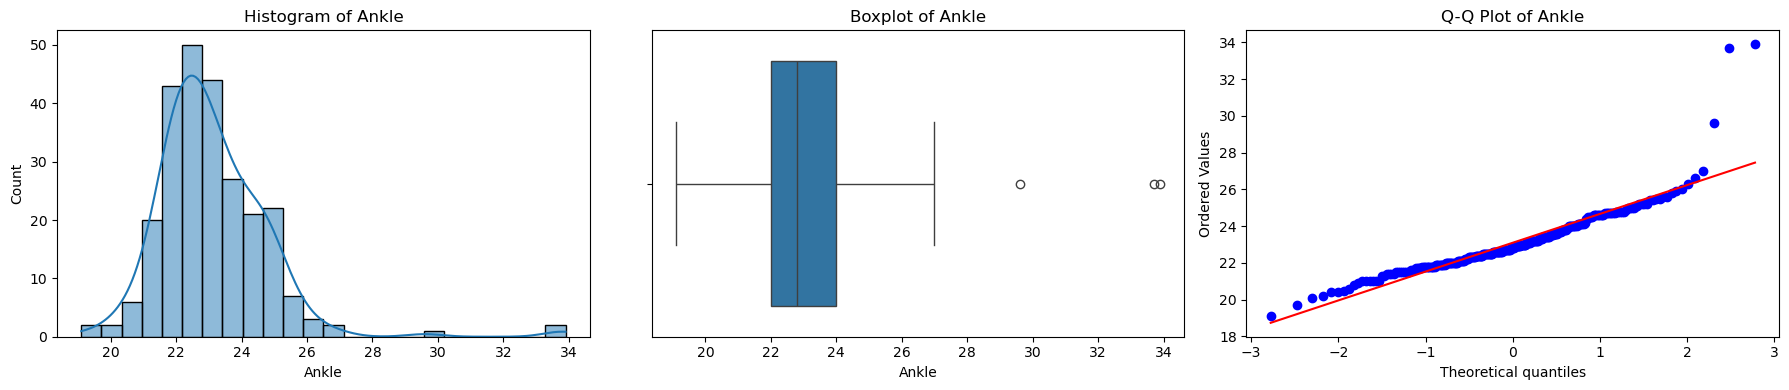

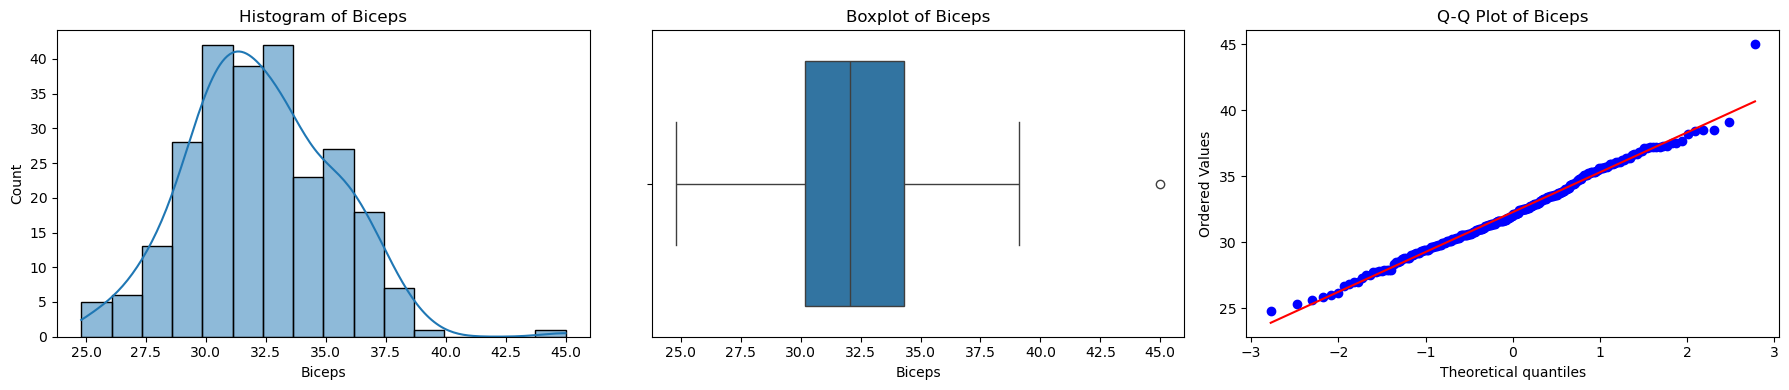

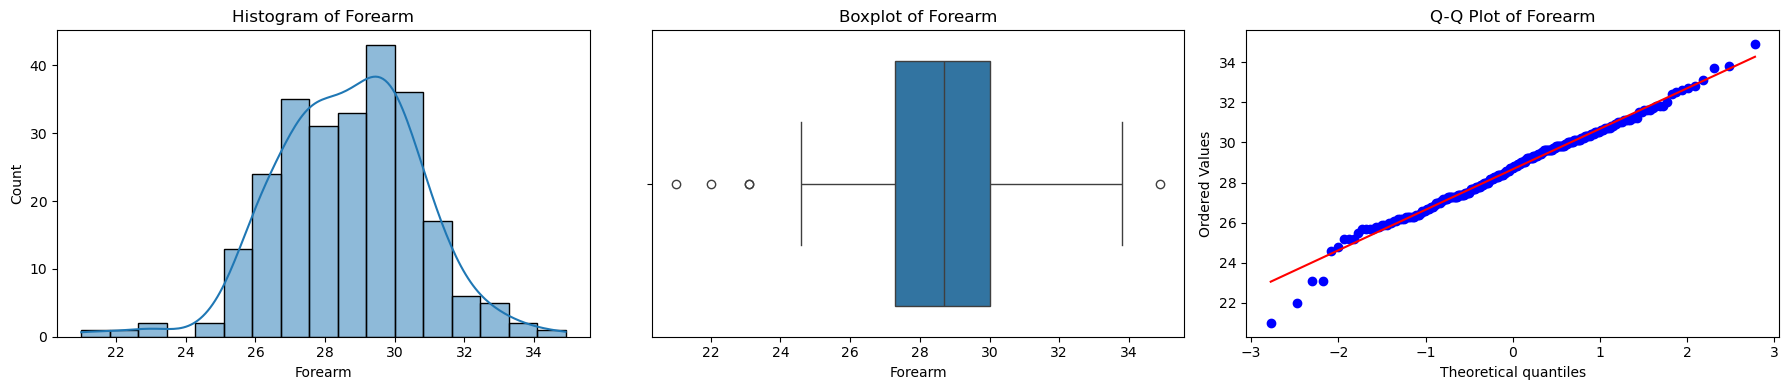

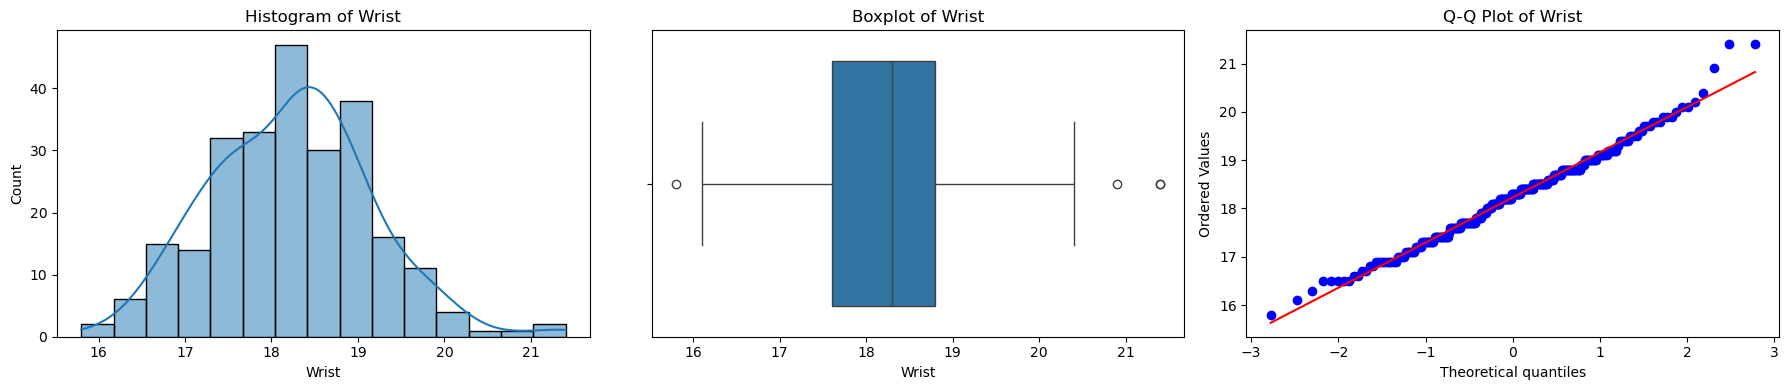

In [64]:


for col in columns:
    if col == 'BodyFat':
        continue
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Histogram
    sns.histplot(data[col], kde=True, ax=axes[0])
    axes[0].set_title(f'Histogram of {col}')

    # Boxplot
    sns.boxplot(x=data[col], ax=axes[1])
    axes[1].set_title(f'Boxplot of {col}')

    # Probability plot (Q-Q plot)
    stats.probplot(data[col], dist="norm", plot=axes[2])
    axes[2].set_title(f'Q-Q Plot of {col}')

    plt.tight_layout()
    plt.show()

### Check outliers

## Outlier Detection
We identify outliers in each feature using the 3-sigma rule (values more than 3 standard deviations from the mean). This helps us understand which features may need special handling.

In [65]:
upperbound, lowerbound = [], []

for col in data.columns:
    if col != 'BodyFat':
        upperbound.append(data[col].mean() + 3 * data[col].std())
        lowerbound.append(data[col].mean() - 3 * data[col].std())

columns = list(data.columns)
outlier_columns = [
    col for col, ub, lb in zip(data.columns, upperbound, lowerbound)
    if col != 'BodyFat' and ((data[col] > ub).any() or (data[col] < lb).any())
]
outlier_columns

['Density',
 'Age',
 'Weight',
 'Height',
 'Neck',
 'Chest',
 'Abdomen',
 'Hip',
 'Thigh',
 'Knee',
 'Ankle',
 'Biceps',
 'Forearm']

### Feature Selection: Correlation and Model-Based Methods
We will now select the most important features for predicting body fat. We'll start by computing and visualizing the correlation matrix, then select features with the highest correlation to 'BodyFat', and finally use a model to further refine our feature selection.

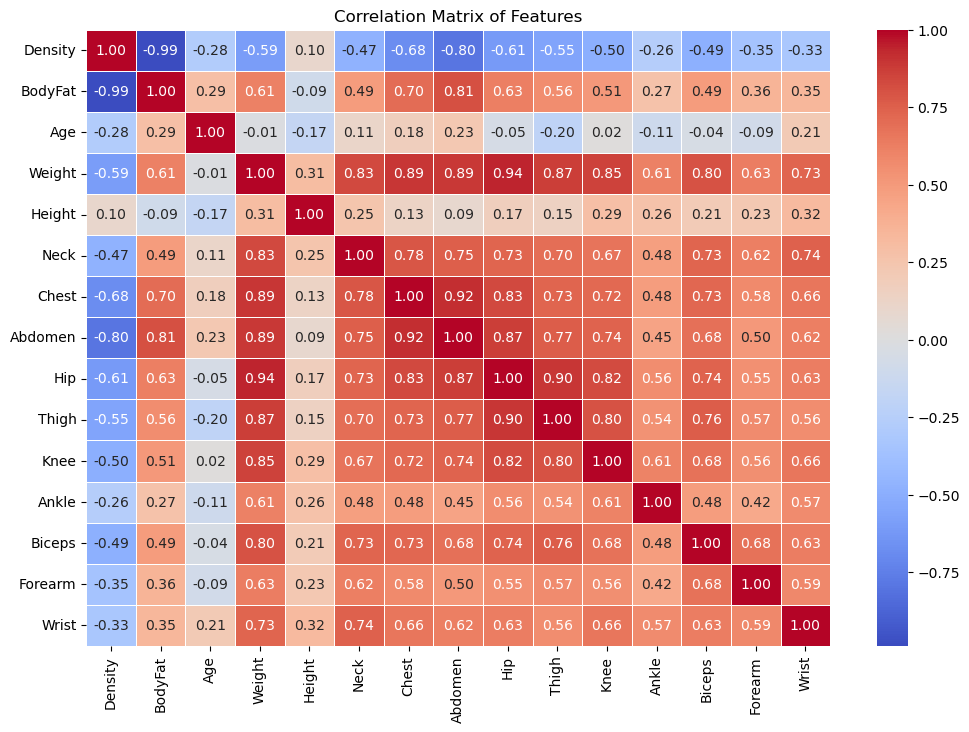

In [66]:
corr_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

In [67]:
correlations = corr_matrix['BodyFat'].drop('BodyFat')
abs_correlations = correlations.abs()
top_features = abs_correlations.sort_values(ascending=False)
print('Features sorted by absolute correlation with BodyFat:')
print(top_features)

Features sorted by absolute correlation with BodyFat:
Density    0.987782
Abdomen    0.813432
Chest      0.702620
Hip        0.625201
Weight     0.612414
Thigh      0.559608
Knee       0.508665
Biceps     0.493271
Neck       0.490592
Forearm    0.361387
Wrist      0.346575
Age        0.291458
Ankle      0.265970
Height     0.089495
Name: BodyFat, dtype: float64


In [68]:
# Step 3: Use a Random Forest model to get feature importances
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
X = data.drop('BodyFat', axis=1)
y = data['BodyFat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print('Feature importances from Random Forest:')
print(feature_importance)

Feature importances from Random Forest:
Density    0.981530
Knee       0.003605
Abdomen    0.003560
Weight     0.002385
Height     0.002105
Chest      0.001538
Wrist      0.001059
Thigh      0.000977
Forearm    0.000828
Age        0.000713
Neck       0.000653
Hip        0.000506
Ankle      0.000329
Biceps     0.000212
dtype: float64


In [69]:
# Select the top 5 important features based on Random Forest feature importances
top5_features = feature_importance.head(5)
print('Top 5 important features:')
print(top5_features)

Top 5 important features:
Density    0.981530
Knee       0.003605
Abdomen    0.003560
Weight     0.002385
Height     0.002105
dtype: float64


In [70]:
# Compute and display the top 5 features using mutual information regression
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
top5_mi_features = mi_series.head(5)
print('Top 5 important features based on mutual information:')
print(top5_mi_features)

Top 5 important features based on mutual information:
Density    3.939874
Abdomen    0.586511
Chest      0.344404
Hip        0.310099
Weight     0.286500
dtype: float64


### Model Selection for Body Fat Prediction
Now that we have selected the most important features, the next step is to choose a suitable regression model for predicting body fat percentage.

#### How to select a model:
- Since 'BodyFat' is a continuous variable, this is a regression problem.
- Common regression models to consider:
  - **Linear Regression**: Simple, interpretable, and a good baseline.
  - **Ridge/Lasso Regression**: Linear models with regularization to prevent overfitting.
  - **Random Forest Regressor**: Handles non-linear relationships and interactions well.
  - **Gradient Boosting Regressor (e.g., XGBoost, LightGBM)**: Often achieves high accuracy for tabular data.
  - **Support Vector Regressor (SVR)**: Can model non-linear relationships with kernels.

We will start with Linear Regression as a baseline, then try more advanced models like Random Forest and Gradient Boosting to compare their performance.

In [71]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Model Training and Evaluation
We will now train and evaluate regression models using the top 5 features selected by Random Forest and Mutual Information. We'll compare their performance using metrics such as RMSE, MAE, and R².

In [72]:
def evaluate_model(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return rmse, mae, r2

features_rf = top5_features.index.tolist()
features_mi = top5_mi_features.index.tolist()

results = {}
for name, features in [('Random Forest', features_rf), ('Mutual Information', features_mi)]:
    X_selected = X[features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    rmse, mae, r2 = evaluate_model(X_train, X_test, y_train, y_test)
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

print('Linear Regression Results:')
for method, metrics in results.items():
    print(f"\nFeatures selected by {method}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

Linear Regression Results:

Features selected by Random Forest:
RMSE: 0.2912
MAE: 0.4020
R2: 0.9937

Features selected by Mutual Information:
RMSE: 0.2457
MAE: 0.3975
R2: 0.9947


### Model Comparison: Linear Regression, Random Forest, and Gradient Boosting
Training and evaluating Random Forest and Gradient Boosting models, and visualize predictions vs. actual values


--- Using features selected by Random Forest ---
Linear Regression: RMSE=0.5396, MAE=0.4020, R2=0.9937


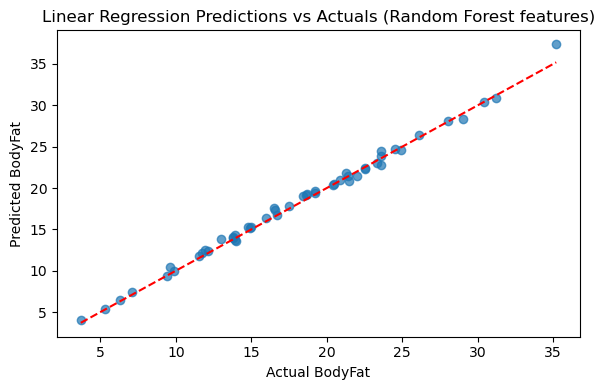

Random Forest: RMSE=0.2028, MAE=0.1478, R2=0.9991
Gradient Boosting: RMSE=0.2371, MAE=0.1739, R2=0.9988

--- Using features selected by Mutual Information ---
Linear Regression: RMSE=0.4957, MAE=0.3975, R2=0.9947


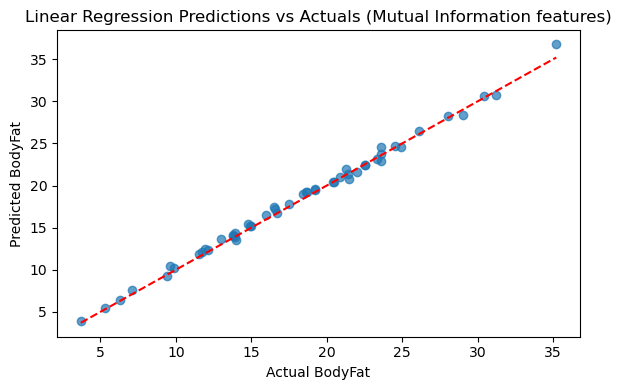

Random Forest: RMSE=0.2242, MAE=0.1622, R2=0.9989
Gradient Boosting: RMSE=0.3594, MAE=0.2239, R2=0.9972


In [73]:
import matplotlib.pyplot as plt
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

for method, features in [('Random Forest', features_rf), ('Mutual Information', features_mi)]:
    print(f'\n--- Using features selected by {method} ---')
    X_selected = X[features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f'{model_name}: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}')
        if model_name == 'Linear Regression':
            plt.figure(figsize=(6,4))
            plt.scatter(y_test, y_pred, alpha=0.7)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
            plt.xlabel('Actual BodyFat')
            plt.ylabel('Predicted BodyFat')
            plt.title(f'{model_name} Predictions vs Actuals ({method} features)')
            plt.tight_layout()
            plt.show()

### Final Model Selection and Deployment Preparation
After comparing several models, we chose the **Random Forest Regressor** trained on the top 5 features selected by Random Forest feature importances. This model achieved the best performance (lowest RMSE and MAE, highest R²) on our test data. Random Forest is robust, handles non-linear relationships, and is less sensitive to outliers, making it ideal for our body fat estimation task.

In the next cell, we will train the final model on the full dataset using these features and save it for deployment.

In [74]:
final_features = top5_features.index.tolist()
X_final = X[final_features]
y_final = y
final_model = RandomForestRegressor(random_state=42)
final_model.fit(X_final, y_final)

RandomForestRegressor(random_state=42)

## Final Model Training and Export
We now train the final Random Forest model using the entire dataset and the top 5 most important features (as determined by Random Forest feature importances). This model is then saved for deployment or use in a Streamlit web application.

In [75]:
import pickle
with open('bodyfat_rf_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)
print('Final Random Forest model saved as bodyfat_rf_model.pkl')

Final Random Forest model saved as bodyfat_rf_model.pkl
